# The hanging chain

In this section the treated problem is the minimization of the potential energy of a chain.  
The following hypothesis were made:
* The chain is represented by a finite number of bars $n_b$. 
* The extreme nodes linking the bars are fixed, leaving $n_j$ free nodes. $n_j=n_b-1$ .

## Model
___
$f(X)$ it's the potential energy of the chain.  
The weight is proportional to the length of the bar.
$$
f(X)=\underset{i=1}{\overset{n_b}{\sum}} \left (L_i \frac{y_i + y_{i-1}}{2} \right)\\
\;\\
\underset{X\in\mathbb{R}^{2n_j}}{\min}f(X) \; s.t. \; h(x)=0\\
$$
This problem is constrained by $h(X)=0$ which idicates that the distance between consecutive nodes must be equal to the length of the bar. There is one constrain per bar.
$$
h_i(X) = \sqrt{(X_i-X_{i-1})^2 + (Y_{i}-Y_{i-1})^2}^2 - L_i^2
$$


## Augmented lagrange 
___

It is asked to solve this problem using the Augmented Langrangian Method for probles with equality constraints.  

$$
\mathcal{L}(X,\lambda,c) = f(X) + \lambda^Th(X)+\frac{c}{2}||h(X)||^2
$$

# CODE
___


In [38]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("seaborn")

> As the input is a 1-D vector containing the x and y positions of each free node, the fonction `NODES` was created in order to separete them in x's and y's and at the same time join the fixed nodes.  
$$
\begin{bmatrix}
   X_{init} & Y_{init}\\
   X_0 & Y_0 \\
   \vdots & \vdots \\
   X_{n_j} & Y_{n_j} \\
   X_{end} & Y_{end} \\ 
\end{bmatrix}
$$


In [2]:
def NODES(_X,_xi,_yi,_xf,_yf):
    m,n = _X.shape
    nodes = np.copy(_X)
    nodes = nodes.reshape(2,n//2).T
    nodes = np.concatenate(([[xi,yi]],nodes),axis=0)
    nodes = np.concatenate((nodes,[[xf,yf]]),axis=0)
    return nodes

## Oracle creation

In the oracles, `global` variables are used to call the position of the fixed nodes and the bar's legth.   

### The modified Energy fonction
$$
f(X)=\underset{i=0}{\overset{n_b}{\sum}} \left (L_i \frac{y_i + y_{i-1}}{2} \right)\\ 
\nabla f(X) = \left [0,0,\cdots, \frac{L_0+L_{1}}{2}, \cdots ,\frac{L_{n_j}+L_{nb}}{2} \right]
$$

In [3]:
def f(_X):
    global yi,yf,Length
    m,n = _X.shape
    temp_L=0.5*(Length[0,:-1]+Length[0,1:])
    F=np.dot(temp_L,_X[0,n//2:].T)+Length[0,0]*yi/2+Length[0,-1]*yf/2
    return F
def g(_X):
    global yi,yf,Length,nb,nj
    m,n = _X.shape
    temp_dy=0.5*(Length[0,:-1]+Length[0,1:])
    G = np.concatenate((np.zeros(shape=(1,n//2)),temp_dy),axis=None)
    return G.reshape(1,2*nj)

### The constrain 
$$
h_i(X) = \sqrt{(X_i-X_{i-1})^2 + (Y_{i}-Y_{i-1})^2}^2 - L_i^2 \;\;;\;\; \forall i \in \{0,1,\cdots,n_b\}\\
Jh(X)=\begin{bmatrix}
   \frac{\partial h_0}{\partial X_0} & \frac{\partial h_0}{\partial X_1} & \cdots & \frac{\partial h_0}{\partial X_{2n_j}} \\
   \vdots & \vdots & & \vdots \\
   \frac{\partial h_{n_b}}{\partial X_0} & \frac{\partial h_{n_b}}{\partial X_1} & \cdots & \frac{\partial h_{n_b}}{\partial X_{2n_j}} \\ 
\end{bmatrix}
$$

In order to ease the calculation of $h_i(X)$ and $Jh(X)$ i used the matrix returned by the fonction `NODES`   
**In the case of $h(x)$**:
$$
\begin{bmatrix}
   X_0 & Y_0 \\
   \vdots & \vdots \\
   X_{n_j} & Y_{n_j} \\
   X_{end} & Y_{end} \\ 
\end{bmatrix}
-
\begin{bmatrix}
   X_{init} & Y_{init}\\
   X_0 & Y_0 \\
   \vdots & \vdots \\
   X_{n_j} & Y_{n_j} \\
\end{bmatrix}
=
\begin{bmatrix}
   X_{0} - X_{init} & Y_0 - Y_{init}\\
   X_1-X_0 & Y_1-Y_0 \\
   \vdots & \vdots \\
   X_{end}-X_{n_j} & Y_{end}-Y_{n_j} \\
\end{bmatrix}
$$
Then the norm of each line is calculated $\sqrt{\Delta X^2_i +\Delta Y^2_i}$ to procede with the calculation of $h(X)$


In [4]:
def h(_X):
    global xi,yi,xf,yf,Length
    m,n = _X.shape
    nodes = NODES(_X,xi,yi,xf,yf)
    li = np.linalg.norm((nodes[1:]-nodes[:-1]),axis=1)
    H = (li**2 - Length**2).T
    return H

**In the case of $Jh(x)$:**  
The procedure was similar but the matrix of the diference between the $Xi$ and $X_{i-1}$ is modified in order to have the same size of the Jacobian, and then is multplied term by term with a matrix of $dX$  

$$
\begin{bmatrix}
   X_{0} - X_{init} & \cdots & X_{0} - X_{init} & Y_0 - Y_{init} & \cdots & Y_0 - Y_{init}\\
   X_1-X_0 & \cdots &X_1-X_0 & Y_1-Y_0&\cdots & Y_1-Y_0 \\
   \vdots &  &\vdots & \vdots &  & \vdots\\
   X_{end}-X_{n_j} & \cdots & X_{end}-X_{n_j} & Y_{end}-Y_{n_j} & \cdots& Y_{end}-Y_{n_j} \\
\end{bmatrix}
*
\begin{bmatrix}
   2d_X & 0     & 0     &0&2d_Y & 0     & 0     &0\\
   -2d_X & 2d_X & 0     &0&  -2d_Y & 2d_Y & 0 &0 \\
   0 &\ddots & \ddots & 0  &0 &\ddots & \ddots & 0 &\\
  0 & \ddots & \ddots & -2d_X & 0 & \ddots & \ddots & -2d_Y  \\
\end{bmatrix}
$$


In [21]:
def Jh(_X):
    global xi,yi,xf,yf,Length
    m , n = _X.shape
    nj = n//2
    nodes = NODES(_X,xi,yi,xf,yf)
    delta = (nodes[1:]-nodes[:-1])
    jx = 2*np.concatenate((np.eye(nj),np.zeros(shape=(1,nj))),axis=0) - 2*np.concatenate((np.zeros(shape=(1,nj)),np.eye(nj)),axis=0)
    dJ = np.concatenate((jx,jx),axis=1)
    JH = np.multiply(np.repeat(delta, repeats=nj,axis=1),dJ) #The repeat fonction repeats each column nj times, and the multiply makes an element-wise multiplication 
    return JH

$$
\phi(X) = f(X) + \lambda_k^Th(X)+\frac{c_k}{2}||h(X)||^2\\
\nabla \phi(X) = \nabla f(X) + Jh(X)^T\cdot\lambda_k^T+c_k \left(Jh(X)^T\cdot h(X)\right) \\
$$

In [5]:
def phi(_X, Lamda, C):
    H,J = oracleH(_X, mode=1)
    F,G = oracleF(_X, mode=1)
    L = F + np.dot(Lamda,H)+C/2*np.linalg.norm(H)**2
    return L
def Gphi( _X, Lamda, C):
    H,J = oracleH(_X, mode=2)
    F,G = oracleF(_X, mode=2)
    GL = G.T + np.dot(J.T,Lamda.T) + C*np.dot(J.T,H)
    return GL

$$
\mathcal{L}(X,\lambda,c) = f(X) + \lambda^Th(X)+\frac{c}{2}||h(X)||^2\\
Jh(X)=\begin{bmatrix}
   \nabla \phi_1 \\
   \vdots \\
   \nabla \phi_{2n_j}\\
   h_0 \\  
   \vdots \\
   h_{n_b}
\end{bmatrix}
$$

In [6]:
def Lagrange( _X, Lamda, C):
    H,J = oracleH(_X, mode=1)
    F,G = oracleF(_X, mode=1)
    L = F + np.dot(Lamda,H)+C/2*np.linalg.norm(H)**2
    return L
def DLagrange( _X, Lamda, C):
    H,J = oracleH(_X, mode=2)
    F,G = oracleF(_X, mode=2)
    GL = np.concatenate((G.T + np.dot(J.T,Lamda.T) + C*np.dot(J.T,H), H), axis=None)
    return GL

In [7]:
def oracleF(X, mode):
    if mode==1:
        return f(X),None 
    elif mode==2:
        return f(X),g(X)
    elif mode==3:
        return None,g(X)
    else:
        print('Not on the list')  
        
def oracleH(X, mode):
    if mode==1:
        return h(X),None 
    elif mode==2:
        return h(X),Jh(X)
    elif mode==3:
        return None,Jh(X)
    else:
        print('Not on the list') 
        
def oraclePhi(X,Lamda,C, mode):
    if mode==1:
        return phi(X,Lamda,C),None 
    elif mode==2:
        return phi(X,Lamda,C),Gphi(X,Lamda,C)
    elif mode==3:
        return None,Gphi(X,Lamda,C)
    else:
        print('Not on the list')  
        
def oracleL(X,Lamda,C, mode):
    if mode==1:
        return Lagrange(X,Lamda,C),None 
    elif mode==2:
        return Lagrange(X,Lamda,C),DLagrange(X,Lamda,C)
    elif mode==3:
        return None,DLagrange(X,Lamda,C)
    else:
        print('Not on the list')  

## The Augmented lagrange method

In [79]:
def Armijo(Xk,lamdak,ck,d,MaxItLineSearch,t0 = 100, theta=0.2, m=0.001):
    p=0
    t = [t0]
    while True:
        phi, gphi = oraclePhi(Xk,lamdak,ck, mode=2)
        phi1, gphi1 = oraclePhi(Xk+t[-1]*d.T,lamdak,ck, mode=1)
        
        if phi1 <= phi + m*t[-1]*np.dot(gphi.T,d):
            return t[-1]
        else:
            t.append(theta*t[-1])
            if p<MaxItLineSearch:
                p+=1
            else:
                print(f'Max iterations \n\t direction: {d} \n\t step:{t[-1]}')
                raise ValueError('Max iteration')

# Minimization of the fonction phi with the gradient method and armijo's line search            
def MinPhi(xk_0, lamdak, ck,MaxIt=1000,tol = 10e-6, MaxItLineSearch=50, step = 100):
    k=0
    Xk =  [xk_0] #Xk is a list that contains the iterated values, the last value is of index -1
    while True:
        phi, gphi = oraclePhi(Xk[-1],lamdak,ck, mode=2)
        if np.linalg.norm(gphi)<tol:
            return Xk[-1]
        else:
            d = -1*gphi
            step = Armijo(Xk[-1],lamdak,ck,d, MaxItLineSearch=MaxItLineSearch, t0 = 100)                          
            Xk.append(Xk[-1] + step*d.T)
            if k<MaxIt:
                k+=1
            else:
                print('Max iterations')
                return None,Xk

def Optimize(x0,lamda0,c0, tol = 10e-6, MaxIt=1000, stepC=0.1):
    k=0
    C = [c0] #list of iterations of c
    Lamda = [lamda0] #list of iterations of Lambda
    Xk =  [x0] 
    Xkh = [] 
    while True:
        Xkh.append([])
        Xk.append(MinPhi(Xk[-1],Lamda[-1],C[-1])) # Minimization of the fonction phi with the gradient method and armijo's line search
        lagrange, gradient = oracleL(Xk[-1],Lamda[-1],C[-1], mode = 2)
        if np.linalg.norm(gradient)<tol:
            #print (f'Converged on {Xk[-1]}')
            return Xk[-1],Lamda[-1],C[-1], k
        else:
            hk,jk = oracleH(Xk[-1], mode=1) 
            Lamda.append(Lamda[-1]+C[-1]*hk.T) #Update of Lambda 
            C.append(C[-1]+stepC) #Update of c
            if k<MaxIt:
                k+=1
            else:
                print('Max iterations algo1')
                return None,Xk,None,Lamda,None,C

## Results
___

In [90]:
%matplotlib inline
def plotchain(a,x0, xi,yi,xf,yf):
    nodes_matrix = NODES(x0, xi,yi,xf,yf)
    XiPoints,YiPoints = nodes_matrix.T[0],nodes_matrix.T[1]
    nodes_matrix = NODES(a, xi,yi,xf,yf)
    XPoints,YPoints = nodes_matrix.T[0],nodes_matrix.T[1]
    print(XPoints,YPoints)
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(XiPoints,YiPoints, linestyle='--', marker='o', label='Initial Position')
    plt.plot(XPoints,YPoints, marker='o', label='Minimal Energy Position')
    plt.legend()

    for i_x, i_y in zip(XPoints,YPoints):
        plt.text(i_x, i_y, '(%.2f,%.2f)'%(i_x,i_y))
    

### First case, 3 bars

Augmented lagrange iterations :4 
[ 0.          2.99999959  7.99999961 11.        ] [ 0.         -4.00000031 -3.99999972  0.        ]


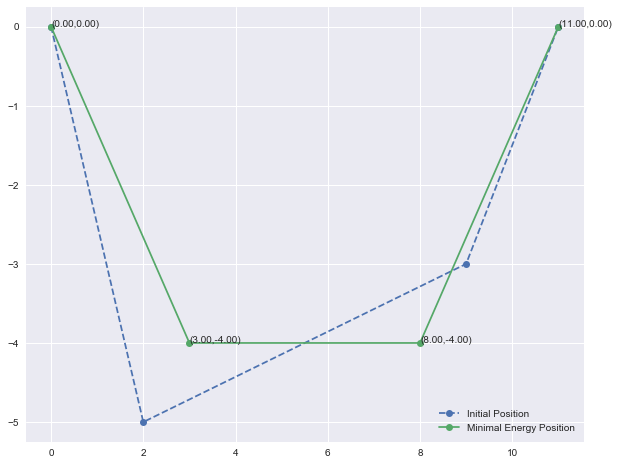

In [95]:
xi=0
yi=0
xf=11
yf=0
nb=3
nj=nb-1
Length = np.ones(shape=(1,nb))*5
x0 = np.array([[2,9,-5,-3]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

x_opt,lamda_opt,c_opt,k = Optimize(x0,lamda0,c0)
print(f'Augmented lagrange iterations :{k} ')
plotchain(x_opt,x0, xi,yi,xf,yf)

Augmented lagrange iterations :49 
[0.         0.15339183 0.33946835 0.5742395  0.76186021 1.        ] [ 0.         -0.36942036 -0.6047385  -0.69066454 -0.62138621 -0.3       ]


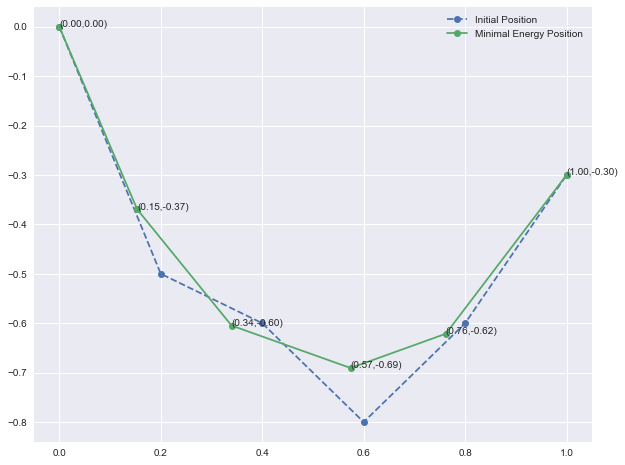

In [92]:
xi=0
yi=0
xf=1
yf=-0.3
nb=5
nj=nb-1
Length = np.array([[0.4,0.3,0.25,0.2,0.4]])
x0 = np.array([[0.2,0.4,0.6,0.8,-0.5,-0.6,-0.8,-0.6]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

x_opt,lamda_opt,c_opt,k = Optimize(x0,lamda0,c0)
print(f'Augmented lagrange iterations :{k} ')
plotchain(x_opt,x0, xi,yi,xf,yf)

Augmented lagrange iterations :49 
[0.         0.15339183 0.33946835 0.5742395  0.76186021 1.        ] [ 0.         -0.36942036 -0.6047385  -0.69066454 -0.62138621 -0.3       ]


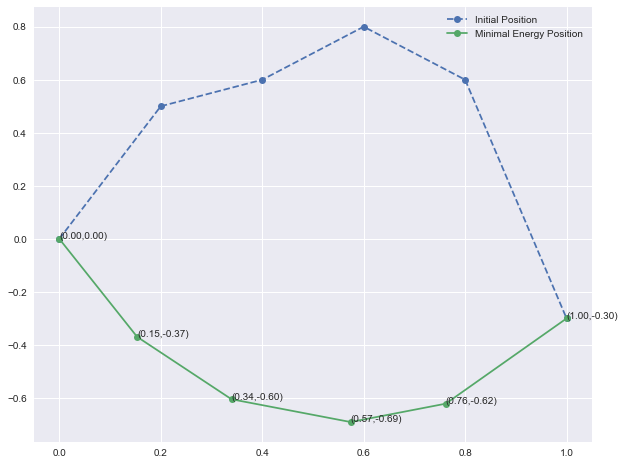

In [93]:
xi=0
yi=0
xf=1
yf=-0.3
nb=5
nj=nb-1
Length = np.array([[0.4,0.3,0.25,0.2,0.4]])
x0 = np.array([[0.2,0.4,0.6,0.8,0.5,0.6,0.8,0.6]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

x_opt,lamda_opt,c_opt,k = Optimize(x0,lamda0,c0)
print(f'Augmented lagrange iterations :{k} ')
plotchain(x_opt,x0, xi,yi,xf,yf)

Augmented lagrange iterations :35 
[0.         0.10364362 0.24138974 0.46264052 0.63214398 0.8       ] [ 0.         -0.38634018 -0.65284693 -0.76925186 -0.66307754 -0.3       ]


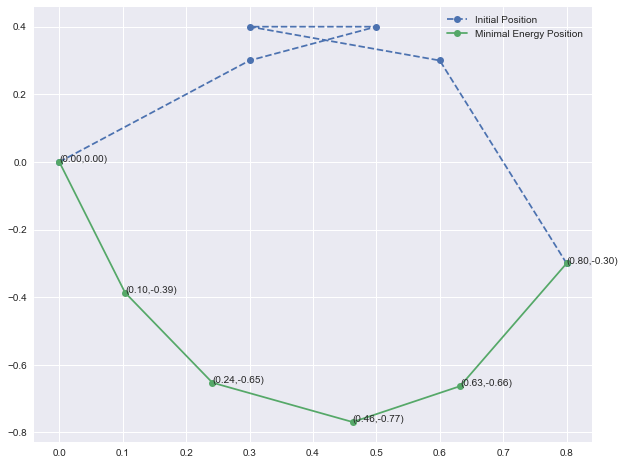

In [94]:
xi=0
yi=0
xf=0.8
yf=-0.3
nb=5
nj=nb-1
Length = np.array([[0.4,0.3,0.25,0.2,0.4]])
x0 = np.array([[0.3,0.5,0.3,0.6,0.3,0.4,0.4,0.3]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

x_opt,lamda_opt,c_opt,k = Optimize(x0,lamda0,c0)
print(f'Augmented lagrange iterations :{k} ')
plotchain(x_opt,x0, xi,yi,xf,yf)